In [1]:
import stim 
import numpy as np
import networkx as nx
from css import *
from graphs import edge_coloring
edge_color_bipartite = edge_coloring.edge_color_bipartite
from graphs.tanner_graph import tanner_graph as tanner_graph
from graphs.edge_coloring import edge_color_bipartite as edge_color_bipartite
import numpy as np


In [2]:
sfcode3 = SurfaceCode(d=3)
sfcode3.H_X, sfcode3.H_Z
Hx = sfcode3.H_X
Hz = sfcode3.H_Z
Lx = sfcode3.L_X
Lz = sfcode3.L_Z

In [3]:
# Build static colorings first
Gx = tanner_graph(Hx, "cx")
Gz = tanner_graph(Hz, "cz")
static_colorings_x = edge_color_bipartite(Gx)
static_colorings_z = edge_color_bipartite(Gz)
print("static coloring X checks: \n", static_colorings_x)
print("static coloring Z checks: \n", static_colorings_z)
colorings_x = static_colorings_x
colorings_z = static_colorings_z

static coloring X checks: 
 [{('cx0', 'q0'), ('cx1', 'q2'), ('cx3', 'q4'), ('cx2', 'q3')}, {('cx3', 'q7'), ('cx0', 'q1'), ('cx2', 'q6'), ('cx1', 'q5')}, {('cx3', 'q5'), ('cx0', 'q3')}, {('cx0', 'q4'), ('cx3', 'q8')}]
static coloring Z checks: 
 [{('cz2', 'q4'), ('cz1', 'q1'), ('cz3', 'q7'), ('cz0', 'q0')}, {('cz2', 'q3'), ('cz0', 'q1'), ('cz1', 'q2'), ('cz3', 'q8')}, {('cz2', 'q6'), ('cz1', 'q4')}, {('cz1', 'q5'), ('cz2', 'q7')}]


In [6]:
import random
from typing import List, Set, Tuple, Callable

In [7]:
def epsilon_check(
    colorings_x: List[Set[Tuple[str, str]]],
    colorings_z: List[Set[Tuple[str, str]]]
) -> Callable[[str], Set[Tuple[str, str]]]:
    """Returns \Epsilon(c) function that gives all edges for check c"""
    from collections import defaultdict
    edges = defaultdict(set)
    for time_step in colorings_x + colorings_z:
        for (c, q) in time_step:
            edges[c].add((c, q))
    
    return lambda c: edges.get(c, set())

In [8]:
def build_edge_time_map(colorings_x, colorings_z, offset=0):
    """Builds Λ(edge) with deterministic edge order within time steps, offset globally."""
    Lambd = {}
    for t, time_step in enumerate(colorings_x + colorings_z, 1):  # t starts at 1
        for (c, q) in sorted(time_step, key=lambda e: (e[0], e[1])):
            Lambd[(c, q)] = t + offset
    return Lambd


In [9]:
# better logic hopefully
def adaptive_extraction_round(ancillas, qubit_index, colorings_x, colorings_z, p1, p2, with_noise=True, p_fail=0.1,time=0):
    circuit = stim.Circuit()
    
    # Initialize ancillas
    circuit.append("R", ancillas)
    circuit.append("H", ancillas)
    if with_noise:
        circuit.append("DEPOLARIZE1", ancillas, p1)
    
    # Build helper functions
    Epsilon = epsilon_check(colorings_x, colorings_z)
    Lambd = build_edge_time_map(colorings_x, colorings_z, offset=time)
    notdone = set()
    failures = set()


    # Process edges in time order
    for (c, q) in sorted(Lambd.keys(), key=lambda e: Lambd[e]):
        failed_earlier = False
        for (other_c, other_q) in Epsilon(c):  
            if (other_c, other_q) in failures and Lambd[(other_c, other_q)] < Lambd[(c, q)]:
                failed_earlier = True
                notdone.add((c,q))
                break
        success_cz = random.random() >= p_fail
        
        if not failed_earlier and success_cz:
            # Perform CZ gate
            c_idx = qubit_index[c]
            q_idx = qubit_index[q]
            
            if c.startswith('cx'):
                
                circuit.append("H", [q_idx])
                if with_noise:
                    circuit.append("DEPOLARIZE1", [q_idx], p1)
            
            circuit.append("CZ", [c_idx, q_idx])
            if with_noise:
                circuit.append("DEPOLARIZE2", [c_idx, q_idx], p2)
            
            if c.startswith('cx'):
                circuit.append("H", [q_idx])
                if with_noise:
                    circuit.append("DEPOLARIZE1", [q_idx], p1)
        elif not failed_earlier and not success_cz:
            failures.add((c, q))
        
    success_checks_x = set()
    success_checks_z = set()
    # Measurement basis depends on check failures
    for c in [name for name in qubit_index if name.startswith(('cx', 'cz'))]:
        c_idx = qubit_index[c]
        check_type = c[:2]  # 'cx' or 'cz'

        if any(e in failures for e in Epsilon(c)):
            circuit.append("MR", [c_idx])
        else:
            circuit.append("H", [c_idx])
            circuit.append("MR", [c_idx])
            if check_type == 'cx':
                success_checks_x.add(c)
            else:
                success_checks_z.add(c)
    successful_checks = {'cx': success_checks_x, 'cz': success_checks_z}  
        
    return circuit, successful_checks, failures, notdone


In [10]:
build_edge_time_map(colorings_x, colorings_z, offset=0)

{('cx0', 'q0'): 1,
 ('cx1', 'q2'): 1,
 ('cx2', 'q3'): 1,
 ('cx3', 'q4'): 1,
 ('cx0', 'q1'): 2,
 ('cx1', 'q5'): 2,
 ('cx2', 'q6'): 2,
 ('cx3', 'q7'): 2,
 ('cx0', 'q3'): 3,
 ('cx3', 'q5'): 3,
 ('cx0', 'q4'): 4,
 ('cx3', 'q8'): 4,
 ('cz0', 'q0'): 5,
 ('cz1', 'q1'): 5,
 ('cz2', 'q4'): 5,
 ('cz3', 'q7'): 5,
 ('cz0', 'q1'): 6,
 ('cz1', 'q2'): 6,
 ('cz2', 'q3'): 6,
 ('cz3', 'q8'): 6,
 ('cz1', 'q4'): 7,
 ('cz2', 'q6'): 7,
 ('cz1', 'q5'): 8,
 ('cz2', 'q7'): 8}

4*2 checks, 9 qubits, ncx, ncz. Hx[i,j], check i qubit j. 
Hx[i,j] = 0 if the edge fall

In [12]:
def H_Xt(bad_edges):
    H_adapted = Hx.copy()
    for (c, q) in bad_edges:
        i = int(c[-1])  # check index
        j = int(q[-1])  # data qubit index (assumes 'q{j}')
        H_adapted[i, j] = 0
    return H_adapted
def H_Zt(bad_edges):
    H_adapted = Hz.copy()
    for (c, q) in bad_edges:
        i = int(c[-1])  # check index
        j = int(q[-1])  # data qubit index (assumes 'q{j}')
        H_adapted[i, j] = 0
    return H_adapted

In [14]:
p1 = 0.001
p2 = .005
p_fail = 0.1

roundata end  {'cx': [{'cx2', 'cx3', 'cx0', 'cx1'}, {'cx3', 'cx1'}, {'cx3', 'cx2'}, {'cx2', 'cx3', 'cx0', 'cx1'}], 'cz': [{'cz2', 'cz3', 'cz0', 'cz1'}, {'cz3', 'cz0', 'cz1'}, {'cz2', 'cz3', 'cz0', 'cz1'}, {'cz2', 'cz3', 'cz0', 'cz1'}]}
check name cx0
[0, 3]
t1 to t2 (0, 3)
offset check_name 0
m1, m2  (-32, -8)
[0 0 0 0]
[0 0 0 0]
opp_offset  6
m_opp -9
[0 0 0 0]
check name cx1
[0, 1, 3]
t1 to t2 (0, 1)
offset check_name 1
m1, m2  (-31, -23)
[0 0 0 0]
t1 to t2 (1, 3)
offset check_name 1
m1, m2  (-23, -7)
[0 0 0 0]
opp_offset  6
m_opp -9
[0 0 0 0]
check name cx2
[0, 2, 3]
t1 to t2 (0, 2)
offset check_name 2
m1, m2  (-30, -14)
[0 0 0 0]
[0 0 0 0]
opp_offset  6
m_opp -9
t1 to t2 (2, 3)
offset check_name 2
m1, m2  (-14, -6)
[0 0 0 0]
check name cx3
[0, 1, 2, 3]
t1 to t2 (0, 1)
offset check_name 3
m1, m2  (-29, -21)
[0 0 0 0]
t1 to t2 (1, 2)
offset check_name 3
m1, m2  (-21, -13)
[0 0 0 0]
opp_offset  6
m_opp -9
t1 to t2 (2, 3)
offset check_name 3
m1, m2  (-13, -5)
[0 0 0 0]
check name cz0
[


=== Multiple Failures ===
H_Xt [[1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0]]
Hx [[1 1 0 1 1 0 0 0 0]
 [0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0]
 [0 0 0 0 1 1 0 1 1]]
H_Zt [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1]]
Hz [[1 1 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 0 0 0]
 [0 0 0 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 1 1]]
C_Zt [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
C_Xt [[1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 0]]
succesful checks {'cx': {'cx2', 'cx1'}, 'cz': {'cz3'}}
not done {('cz1', 'q5'), ('cz2', 'q7'), ('cx3', 'q8'), ('cz1', 'q4'), ('cz2', 'q3'), ('cz2', 'q6'), ('cx0', 'q4'), ('cz1', 'q2'), ('cz0', 'q1'), ('cx3', 'q5'), ('cx0', 'q3')}
fail gates {('cz1', 'q1'), ('cz0', 'q0'), ('cx3', 'q7'), ('cx0', 'q1'), ('cz2', 'q4')}


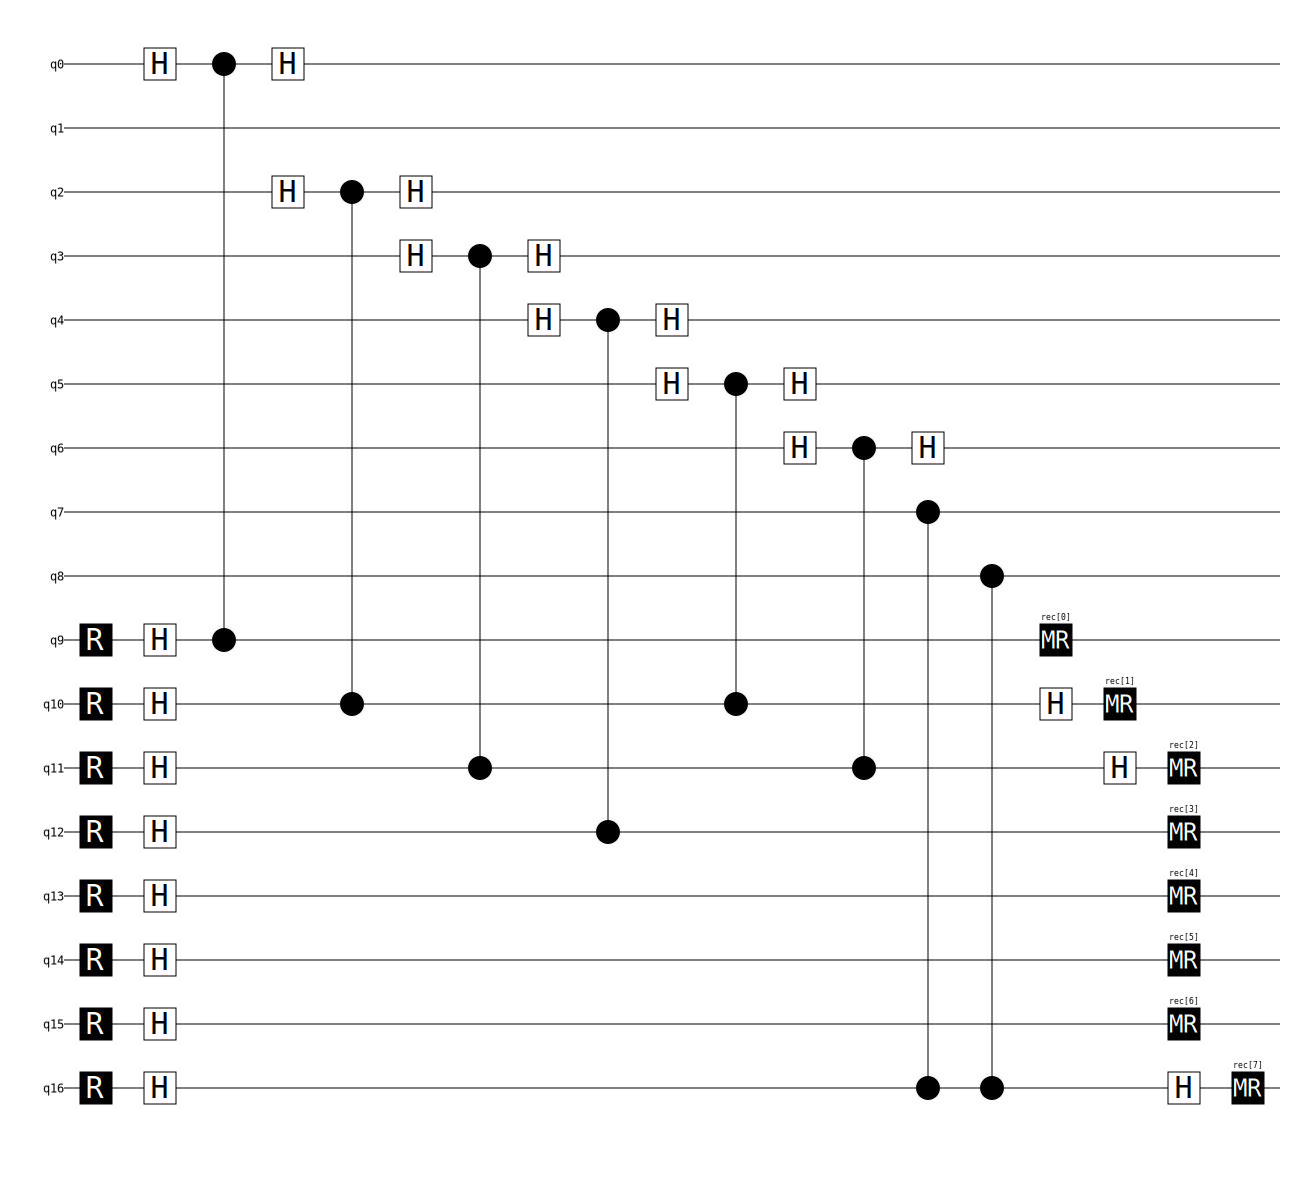

In [16]:
random.seed(2025)  # Different seed

print("\n=== Multiple Failures ===")
circuit, sc, fails, nd = adaptive_extraction_round(
    ancillas, qubit_index, colorings_x, colorings_z,
    p1, p2, with_noise=False, p_fail=0.1
)
bad_edges = fails.union(nd)
bad_edges_x = {(c, q) for (c, q) in bad_edges if c.startswith("cx")}
bad_edges_z = {(c, q) for (c, q) in bad_edges if c.startswith("cz")}
C_Zt = (Hx@H_Zt(bad_edges_z).T)%2
C_Xt = (Hz@H_Xt(bad_edges_x).T)%2
print('H_Xt', H_Xt(bad_edges_x))
print('Hx', Hx)
print('H_Zt', H_Zt(bad_edges_z))
print('Hz', Hz)
print('C_Zt', C_Zt)
print('C_Xt', C_Xt)
print('succesful checks', sc)
print('not done', nd)
print('fail gates', fails)
circuit.diagram("timeline-svg")

In [21]:
random.seed(2025)  #  seed
sfcode3 = SurfaceCode(d=3)
sfcode3.H_X, sfcode3.H_Z
Hx = sfcode3.H_X
Hz = sfcode3.H_Z
Lx = sfcode3.L_X
Lz = sfcode3.L_Z
Gx = tanner_graph(Hx, "cx")
Gz = tanner_graph(Hz, "cz")
colorings_x = edge_color_bipartite(Gx)
colorings_z = edge_color_bipartite(Gz)

cx, n = Hx.shape
cz, _ = Hz.shape

qubit_index = {f"q{i}": i for i in range(n)}
qubit_index.update({f"cx{i}": n + i for i in range(cx)})
qubit_index.update({f"cz{i}": n + cx + i for i in range(cz)})

data = [qubit_index[f"q{i}"] for i in range(n)]
check_x = [qubit_index[f"cx{i}"] for i in range(cx)]
check_z = [qubit_index[f"cz{i}"] for i in range(cz)]
ancillas = check_x + check_z
total_ancillas = len(ancillas)
# Track successful checks per round
num_rounds = 2
round_data = {
	'cx': [[] for _ in range(num_rounds+2)],  # +2 for bookend rounds
	'cz': [[] for _ in range(num_rounds+2)]
}

# Initial noiseless round
circuit, successes, failures, notdone = adaptive_extraction_round(
	ancillas, qubit_index, colorings_x, colorings_z,
	p1, p2, with_noise=False, p_fail=0,time=0
)
round_data['cx'][0] = set(successes['cx'])
round_data['cz'][0] = set(successes['cz'])
# print('roundata start ', round_data)
Cz_list = []
Cx_list = []
Cz_list.append(np.zeros((cx, cz), dtype=int))
Cx_list.append(np.zeros((cz, cx), dtype=int))
# Noisy rounds
Hx_adapted_list = []
Hz_adapted_list = []

for r in range(1, num_rounds+1):
	round_circuit, successes, failures, notdone = adaptive_extraction_round(
		ancillas, qubit_index, colorings_x, colorings_z,
		p1, p2, with_noise=True, p_fail=0.1,time=r
	)
	circuit += round_circuit
	round_data['cx'][r] = set(successes['cx'])
	round_data['cz'][r] = set(successes['cz'])
	bad_edges = failures.union(notdone)
	bad_edges_x = {(c, q) for (c, q) in bad_edges if c.startswith("cx")}
	bad_edges_z = {(c, q) for (c, q) in bad_edges if c.startswith("cz")}
	Hxt = H_Xt(bad_edges_x)
	Hzt = H_Zt(bad_edges_z)
	C_Zt = (Hx@H_Zt(bad_edges_z).T)%2
	C_Xt = (Hz@H_Xt(bad_edges_x).T)%2
	Hx_adapted_list.append(H_Xt(bad_edges_x))
	Hz_adapted_list.append(H_Zt(bad_edges_z))
	Cz_list.append(C_Zt)
	Cx_list.append(C_Xt)
# print('roundata after loop ', round_data)

# Final noiseless round
round_circuit, successes, failures, notdone = adaptive_extraction_round(
	ancillas, qubit_index, colorings_x, colorings_z,
	p1, p2, with_noise=False, p_fail=0, time=num_rounds+1
)
circuit += round_circuit
round_data['cx'][-1] = set(successes['cx'])
round_data['cz'][-1] = set(successes['cz'])
Cz_list.append(np.zeros((cx, cz), dtype=int))
Cx_list.append(np.zeros((cz, cx), dtype=int))
print('roundata end ', round_data)
num_rounds_total = num_rounds + 2

for check_type, C_list, opposite_type, num_checks in [
	('cx', Cz_list, 'cz', cx),
	('cz', Cx_list, 'cx', cz)
]:
	for i in range(num_checks):
		check_name = f"{check_type}{i}"
		print('check name', check_name)
		# Find all rounds where this check succeeded
		success_rounds = [t for t in range(num_rounds_total) if check_name in round_data[check_type][t]]
		print((success_rounds))
		# Loop over consecutive pairs of successful rounds
		for k in range(len(success_rounds) - 1):
			# print('k', k)
			t1 = success_rounds[k]
			t2 = success_rounds[k + 1]
			print('t1 to t2', (t1, t2))

			# Measurement record indices
			offset = ancillas.index(qubit_index[check_name])
			print("offset check_name", offset)
			# print(offset)
			m1 = -(num_rounds_total - t1) * total_ancillas + offset
			m2 = -(num_rounds_total - t2) * total_ancillas + offset
			print("m1, m2 ", (m1, m2))
			detector_targets = [stim.target_rec(m1), stim.target_rec(m2)]
			# Add intermediate corrections based on commutation
			# Choose appropriate time range depending on check type
			if check_type == 'cx':
				t_mid_range = range(t1, t2)  # include t1, exclude t2
			else:
				t_mid_range = range(t1 + 1, t2 + 1)  # exclude t1, include t2

			for t_mid in t_mid_range:
				comm_row = C_list[t_mid][i] # = H_X[i,:]@(\tilder{H}_{Z,t''})^T mod 2.
				print(comm_row)
				for j, val in enumerate(comm_row):
					opp_check = f"{opposite_type}{j}"
					if opp_check not in round_data[opposite_type][t_mid]:  # check failed or incomplete
						# print('fail opposite check ' +str(opp_check)+' at t''= '+ str(t_mid))
						opp_offset = ancillas.index(qubit_index[opp_check])
						print("opp_offset ", opp_offset)
						m_opp = -(num_rounds_total - t_mid) * total_ancillas + opp_offset
						print("m_opp", m_opp)
						if val == 1:
							detector_targets.append(stim.target_rec(m_opp))
					
			# Append to circuit
			circuit.append("DETECTOR", detector_targets)

roundata end  {'cx': [{'cx2', 'cx3', 'cx0', 'cx1'}, {'cx3', 'cx0', 'cx1'}, {'cx2', 'cx3', 'cx0', 'cx1'}, {'cx2', 'cx3', 'cx0', 'cx1'}], 'cz': [{'cz2', 'cz3', 'cz0', 'cz1'}, {'cz2', 'cz3', 'cz0', 'cz1'}, {'cz2', 'cz3', 'cz0', 'cz1'}, {'cz2', 'cz3', 'cz0', 'cz1'}]}
check name cx0
[0, 1, 2, 3]
t1 to t2 (0, 1)
offset check_name 0
m1, m2  (-32, -24)
[0 0 0 0]
t1 to t2 (1, 2)
offset check_name 0
m1, m2  (-24, -16)
[0 0 0 0]
t1 to t2 (2, 3)
offset check_name 0
m1, m2  (-16, -8)
[0 0 0 0]
check name cx1
[0, 1, 2, 3]
t1 to t2 (0, 1)
offset check_name 1
m1, m2  (-31, -23)
[0 0 0 0]
t1 to t2 (1, 2)
offset check_name 1
m1, m2  (-23, -15)
[0 0 0 0]
t1 to t2 (2, 3)
offset check_name 1
m1, m2  (-15, -7)
[0 0 0 0]
check name cx2
[0, 2, 3]
t1 to t2 (0, 2)
offset check_name 2
m1, m2  (-30, -14)
[0 0 0 0]
[0 0 0 0]
t1 to t2 (2, 3)
offset check_name 2
m1, m2  (-14, -6)
[0 0 0 0]
check name cx3
[0, 1, 2, 3]
t1 to t2 (0, 1)
offset check_name 3
m1, m2  (-29, -21)
[0 0 0 0]
t1 to t2 (1, 2)
offset check_name 3

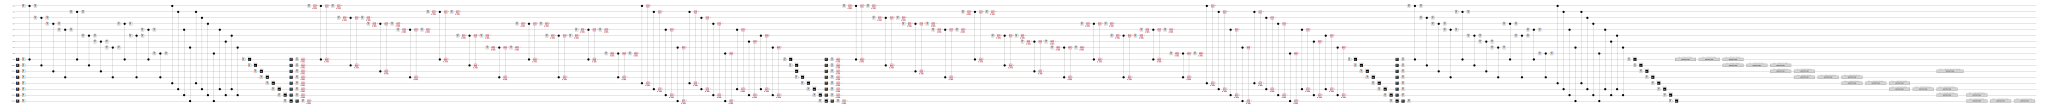

In [22]:
circuit.diagram("timeline-svg")

In [23]:
circuit.detector_error_model()

stim.DetectorErrorModel('''
    error(0.001667) D0
    error(0.00266533) D0 D1
    error(0.00100167) D0 D1 D11
    error(0.000334114) D0 D1 D11 D14
    error(0.000668004) D0 D1 D14
    error(0.00100167) D0 D1 D14 D17
    error(0.000334114) D0 D1 D17
    error(0.00266467) D0 D6
    error(0.000334114) D0 D6 D14
    error(0.000334114) D0 D6 D14 D17
    error(0.00266467) D0 D6 D17
    error(0.001001) D0 D8
    error(0.001001) D0 D8 D14 D17
    error(0.002) D0 D9
    error(0.002) D0 D9 D14 D17
    error(0.00133445) D0 D11
    error(0.000667335) D0 D11 D14
    error(0.000334114) D0 D14
    error(0.00564702) D1
    error(0.00266533) D1 D2
    error(0.00100167) D1 D2 D12
    error(0.000334114) D1 D2 D12 D15
    error(0.000668004) D1 D2 D15
    error(0.00100167) D1 D2 D15 D18
    error(0.000334114) D1 D2 D18
    error(0.000668004) D1 D4
    error(0.000334114) D1 D4 D14
    error(0.000668004) D1 D4 D14 D15
    error(0.000334114) D1 D4 D14 D18
    error(0.000334114) D1 D4 D15
    error(0.00033411